# Практическое задание

Есть данные о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения.

## Описание данных

- city – город
- phone – основное устройство, которое использует водитель
- signup_date – дата регистрации аккаунта (YYYYMMDD)
- last_trip_date – дата последней поездки (YYYYMMDD)
- avg_dist – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- avg_rating_by_driver – средняя оценка поездок водителем
- avg_rating_of_driver – средняя оценка поездок водителя
- surge_pct – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- avg_surge – средний множитель всплеска за все поездки этого водителя
- trips_in_first_30_days – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- luxury_car_user – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- weekday_pct – процент поездок пользователя, совершенных в будние дни

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as ss
import scikit_posthocs as sp
import pingouin as pg

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
churn = pd.read_csv("https://stepik.org/media/attachments/lesson/406362/churn.csv")

In [3]:
churn.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
churn.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

In [5]:
churn.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [8]:
#готовим данные

churn.last_trip_date = pd.to_datetime(churn.last_trip_date)
churn.signup_date = pd.to_datetime(churn.signup_date)

churn['days_since_last_trip'] = churn.last_trip_date.max() - churn.last_trip_date
churn['days_since_last_trip'] = churn['days_since_last_trip'].dt.days

churn['churn'] = churn.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')

# 1

Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city).

In [9]:
pd.crosstab(churn.churn, churn.city)

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


In [10]:
ss.chi2_contingency(pd.crosstab(churn.churn, churn.city))

(3821.5510225559633,
 0.0,
 2,
 array([[10315.89328,  6320.3096 , 14559.79712],
        [ 6218.10672,  3809.6904 ,  8776.20288]]))

In [11]:
pg.chi2_independence(churn, "churn", "city")

(city           Astapor  King's Landing   Winterfell
 churn                                              
 churn      10315.89328       6320.3096  14559.79712
 not_churn   6218.10672       3809.6904   8776.20288,
 city       Astapor  King's Landing  Winterfell
 churn                                         
 churn        12306            3767       15123
 not_churn     4228            6363        8213,
                  test    lambda         chi2  dof  pval    cramer  power
 0             pearson  1.000000  3821.551023  2.0   0.0  0.276462    1.0
 1        cressie-read  0.666667  3788.042430  2.0   0.0  0.275247    1.0
 2      log-likelihood  0.000000  3767.315031  2.0   0.0  0.274493    1.0
 3       freeman-tukey -0.500000  3791.421829  2.0   0.0  0.275370    1.0
 4  mod-log-likelihood -1.000000  3849.643594  2.0   0.0  0.277476    1.0
 5              neyman -2.000000  4073.406300  2.0   0.0  0.285426    1.0)

# 2

Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

Проверим распределение на нормальность:

In [13]:
pg.normality(churn, "trips_in_first_30_days", "city", method="normaltest")

,W,pval,normal
King's Landing,12011.013892,0.0,False
Astapor,18186.739338,0.0,False
Winterfell,21390.545655,0.0,False


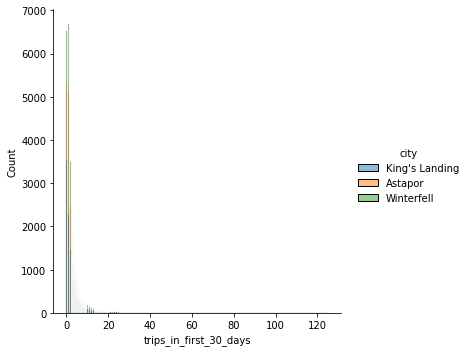

In [14]:
sns.displot(data=churn, x="trips_in_first_30_days", hue="city")

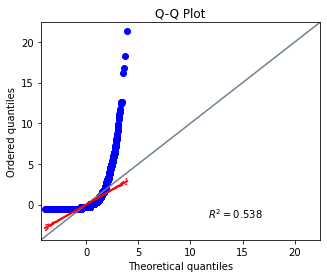

In [15]:
pg.qqplot(churn.query("city == 'Astapor'").trips_in_first_30_days)

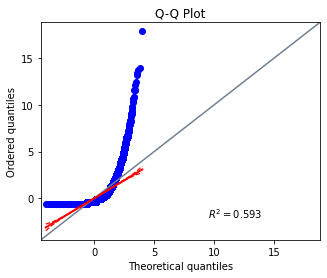

In [16]:
pg.qqplot(churn.query("city == 'Winterfell'").trips_in_first_30_days)

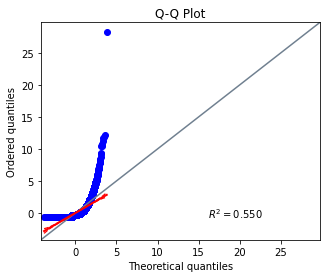

In [17]:
pg.qqplot(churn[churn.city == "King's Landing"].trips_in_first_30_days)

# 3

Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

Обнаружены ли статистически значимые различия?

In [19]:
ss.kruskal(churn.query("city == 'Astapor'").trips_in_first_30_days, 
           churn.query("city == 'Winterfell'").trips_in_first_30_days, 
           churn[churn.city == "King's Landing"].trips_in_first_30_days)

KruskalResult(statistic=221.32105325320535, pvalue=8.724567791804361e-49)

In [20]:
pg.kruskal(data=churn, dv="trips_in_first_30_days", between="city")

,Source,ddof1,H,p-unc
Kruskal,city,2,221.321053,8.724568e-49


Сделаем попарные сравнения:

In [21]:
sp.posthoc_dunn(a=churn, val_col="trips_in_first_30_days", group_col="city", p_adjust="holm")

,Astapor,King's Landing,Winterfell
Astapor,1.000000e+00,1.313616e-09,2.448501e-49
King's Landing,1.313616e-09,1.000000e+00,8.440212e-10
Winterfell,2.448501e-49,8.440212e-10,1.000000e+00


In [22]:
pg.pairwise_ttests(data=churn, dv="trips_in_first_30_days", between="city", padjust="holm",
                  parametric=False)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,city,Astapor,King's Landing,False,False,80357689.5,two-sided,9.911753e-09,9.911753e-09,holm,-0.137636
1,city,Astapor,Winterfell,False,False,176380612.5,two-sided,4.223146e-51,1.266944e-50,holm,-0.132722
2,city,King's Landing,Winterfell,False,False,113477615.0,two-sided,2.459055e-09,4.918110e-09,holm,0.008143


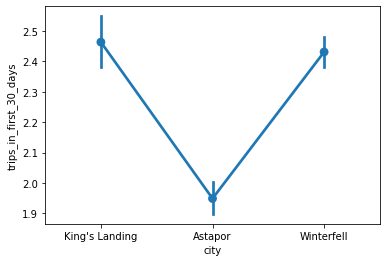

In [26]:
sns.pointplot(data=churn, x="city", y="trips_in_first_30_days")

In [28]:
churn.groupby("city").trips_in_first_30_days.describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Astapor,16534.0,1.948651,3.333600,0.0,0.0,1.0,2.0,73.0
King's Landing,10130.0,2.463672,4.326140,0.0,0.0,1.0,3.0,125.0
Winterfell,23336.0,2.431179,3.835147,0.0,0.0,1.0,3.0,71.0


# 4

Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [29]:
ss.mannwhitneyu(churn.query("churn == 'churn'").trips_in_first_30_days,
                churn.query("churn == 'not_churn'").trips_in_first_30_days)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

In [30]:
pg.mwu(churn.query("churn == 'churn'").trips_in_first_30_days,
       churn.query("churn == 'not_churn'").trips_in_first_30_days)

,U-val,alternative,p-val,RBC,CLES
MWU,234767452.0,two-sided,0.0,0.199579,0.400211


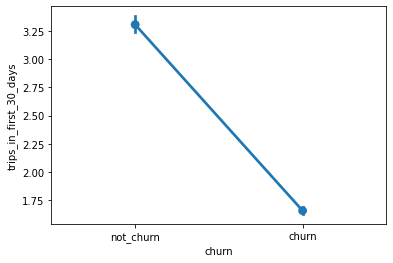

In [31]:
sns.pointplot(data=churn, x="churn", y="trips_in_first_30_days")

In [32]:
churn.groupby("churn").trips_in_first_30_days.describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
churn,31196.0,1.658482,2.654222,0.0,0.0,1.0,2.0,73.0
not_churn,18804.0,3.306318,4.986743,0.0,0.0,2.0,4.0,125.0
